# Clustering on DeepFold Embeddings
Haerang Lee

I'm going to take Skyler's DeepFold embeddings. Those files are in `embeddings/DeepFold` in the GCS bucket.

Then let me run some clustering models on top of it.

**Silly question**: If I want to put this notebook under a directory, how do I access `utils` in the parent directory? Right now I just put my notebook in the home dir.

In [925]:
from google.cloud import storage
import argparse
import gzip
import os
import sys
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from utils import gcs_utils as gcs

In [994]:
# Get all the keys from gcs
allkeys = gcs.list_keys()

In [996]:
unique_dir = []
for key in allkeys:
    if key.split("/")[0:2] not in unique_dir:
        unique_dir.append(key.split("/")[0:2])

unique_dir

[['', 'annotations'],
 ['UP000005640_9606_HUMAN.tar'],
 ['UP000005640_9606_HUMAN', 'cif'],
 ['UP000005640_9606_HUMAN', 'pdb'],
 ['alphafold_dbs', 'mgnify'],
 ['alphafold_dbs', 'params'],
 ['alphafold_dbs', 'pdb70'],
 ['alphafold_dbs', 'small_bfd'],
 ['alphafold_dbs', 'uniclust30'],
 ['alphafold_dbs', 'uniref90'],
 ['annotations', ''],
 ['annotations', 'blast_annotations.csv'],
 ['annotations', 'blast_annotations_legacy_do_not_use.csv'],
 ['c5.go.mf.v7.4.symbols.gmt'],
 ['clusters', ''],
 ['clusters', 'random_control_clusters.csv'],
 ['embeddings', ''],
 ['embeddings', 'DeepFold'],
 ['embeddings', 'SeqVec'],
 ['run_stats.csv'],
 ['structure_files', 'atom_sites'],
 ['structure_files', 'sequences']]

In [995]:
# What's in here?
allkeys[0:10]

['/annotations/blast_annotations.csv',
 'UP000005640_9606_HUMAN.tar',
 'UP000005640_9606_HUMAN/cif/AF-A0A024R1R8-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A024RBG1-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A024RCN7-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H5-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H7-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H8-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H9-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6I0-F1-model_v1.cif.gz']

In [626]:
# How many files are there?
len(allkeys)

46838

In [627]:
# I just want the DeepFold embedding files
for k in allkeys:
    if "embed" in k:
        print(k)

embeddings/
embeddings/DeepFold/
embeddings/DeepFold/embeddings_0.csv
embeddings/DeepFold/embeddings_1.csv
embeddings/DeepFold/embeddings_10.csv
embeddings/DeepFold/embeddings_11.csv
embeddings/DeepFold/embeddings_12.csv
embeddings/DeepFold/embeddings_13.csv
embeddings/DeepFold/embeddings_14.csv
embeddings/DeepFold/embeddings_15.csv
embeddings/DeepFold/embeddings_16.csv
embeddings/DeepFold/embeddings_17.csv
embeddings/DeepFold/embeddings_18.csv
embeddings/DeepFold/embeddings_19.csv
embeddings/DeepFold/embeddings_2.csv
embeddings/DeepFold/embeddings_20.csv
embeddings/DeepFold/embeddings_3.csv
embeddings/DeepFold/embeddings_4.csv
embeddings/DeepFold/embeddings_5.csv
embeddings/DeepFold/embeddings_6.csv
embeddings/DeepFold/embeddings_7.csv
embeddings/DeepFold/embeddings_8.csv
embeddings/DeepFold/embeddings_9.csv


In [628]:
prefix = 'embeddings/DeepFold'
keys = gcs.list_file_paths(prefix)

There are 21 files in the embeddings folder, each containing 1,000 proteins (except the last one). Here are the file names.

In [629]:
keys

['gs://capstone-fall21-protein/embeddings/DeepFold/',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_0.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_1.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_10.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_11.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_12.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_13.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_14.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_15.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_16.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_17.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_18.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_19.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_2.csv',
 'gs://capstone-fall21-pro

One of those embeddings files contains 1,000 proteins.
The first three elements appear to be empty data, or just `'', '0', '1\n0'`. The remaining 2,000 are pairs of protein name and relevant embedding (2\*1000).

In [630]:
keys[1]

'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_0.csv'

In [632]:
key = gcs.uri_to_bucket_and_key(keys[2])[1]
key

'embeddings/DeepFold/embeddings_1.csv'

## Download and Parse DeepFold Embeddings

In [637]:
# Let me download one and play with it.
df_emb = gcs.download_text(key)

In [638]:
# Decode it then split it into a list.
df_emb_decode = df_emb.split(",")

In [639]:
# 1002 items, where the first few are not just metadata or empty strings
len(df_emb_decode)

1002

In [641]:
# Item index 2 is where the real data starts. That's the protein name.
df_emb_decode[0:2]

['protein_id', 'deepfold\nQ13200']

In [642]:
df_emb_decode[3]

'"[5.96747687e-03 0.00000000e+00 1.85894519e-02 0.00000000e+00\n 0.00000000e+00 0.00000000e+00 1.58412028e-02 6.06489480e-02\n 1.20269276e-01 0.00000000e+00 1.09242159e-03 0.00000000e+00\n 3.65636125e-02 2.16107760e-02 0.00000000e+00 2.00002007e-02\n 0.00000000e+00 2.02822257e-02 4.80303104e-04 0.00000000e+00\n 1.04048893e-01 0.00000000e+00 3.60421650e-02 4.14775945e-02\n 1.24980044e-02 0.00000000e+00 6.08191919e-03 1.06642962e-01\n 2.12292913e-02 3.20112929e-02 9.43305343e-03 7.48014897e-02\n 0.00000000e+00 0.00000000e+00 2.28349902e-02 0.00000000e+00\n 7.61815533e-03 1.36520118e-01 1.64051410e-02 0.00000000e+00\n 8.02622437e-02 0.00000000e+00 4.27073240e-02 2.12408379e-02\n 9.43467468e-02 0.00000000e+00 2.17287447e-02 0.00000000e+00\n 3.11355650e-01 0.00000000e+00 1.02889389e-01 0.00000000e+00\n 1.73968710e-02 0.00000000e+00 0.00000000e+00 2.08255574e-02\n 8.63376930e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 3.49744782e-02 2.44668610e-02 0.00000000e+00 8.66087794e-04\n 0.000

In [643]:
# Let's figure out how to parse the DeepFold embedding. 
# There's a lot of funny stuff in here.
# First, get rid of the file number at the end and just keep the vector

sample_emb = df_emb_decode[3].rsplit('\n', 1)[0]

In [648]:
sample_emb[0:40]

'"[5.96747687e-03 0.00000000e+00 1.858945'

In [651]:
# Now get rid of the double quotes and brackets to just get the values of the array

sample_emb_np = np.array(sample_emb[2:-2].split()).astype(float)
sample_emb_np

array([5.96747687e-03, 0.00000000e+00, 1.85894519e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.58412028e-02, 6.06489480e-02,
       1.20269276e-01, 0.00000000e+00, 1.09242159e-03, 0.00000000e+00,
       3.65636125e-02, 2.16107760e-02, 0.00000000e+00, 2.00002007e-02,
       0.00000000e+00, 2.02822257e-02, 4.80303104e-04, 0.00000000e+00,
       1.04048893e-01, 0.00000000e+00, 3.60421650e-02, 4.14775945e-02,
       1.24980044e-02, 0.00000000e+00, 6.08191919e-03, 1.06642962e-01,
       2.12292913e-02, 3.20112929e-02, 9.43305343e-03, 7.48014897e-02,
       0.00000000e+00, 0.00000000e+00, 2.28349902e-02, 0.00000000e+00,
       7.61815533e-03, 1.36520118e-01, 1.64051410e-02, 0.00000000e+00,
       8.02622437e-02, 0.00000000e+00, 4.27073240e-02, 2.12408379e-02,
       9.43467468e-02, 0.00000000e+00, 2.17287447e-02, 0.00000000e+00,
       3.11355650e-01, 0.00000000e+00, 1.02889389e-01, 0.00000000e+00,
       1.73968710e-02, 0.00000000e+00, 0.00000000e+00, 2.08255574e-02,
      

In [652]:
# Size is as expected 

sample_emb_np.shape

(398,)

In [686]:
len(sample_emb_np)

398

In [851]:
sum(sample_emb_np == 0)

194

In [696]:
def protein_file_processor(key):
    i = 2
    X = np.empty((0,398), dtype=float)
    protein = np.empty((0,1), dtype=str)

    df_emb_decode = gcs.download_text(key).decode('utf-8').split(",")    
    
    # If any embedding hasn't been generated, then put it into missing 
    missing_protein=[]

    while i < len(df_emb_decode):
        pair = df_emb_decode[i].rsplit('\n', 1)
        # parse feature vec. Remove double quotes and brackets. Split and cast as float.
        feature_vec = np.array(pair[0][2:-2].split()).astype(float)
        protein_id = pair[1]

        # Only take the vector if we have a feature vec of length 398 
        if len(feature_vec) != 398:
            missing_protein.append(protein_id)
            i+=1
            continue

        X = np.concatenate((X, feature_vec.reshape(1,398)))
        protein = np.append(protein, protein_id)
        i+=1
    
    return X, protein, missing_protein 


In [743]:
X, protein, missing_protein = protein_file_processor(key)

In [744]:
print(X.shape)
print(protein.shape)
print(len(missing_protein))

(991, 398)
(991,)
9


# Clustering

In [699]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=5).fit(X)

In [700]:
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[ -1 540]
 [  0 405]
 [  1  19]
 [  2  17]
 [  3   5]]


---

# Hyperparam tuning

Next steps for me:
1. I’m going to add in some form of evaluation metrics. Exploring using BLAST or other more traditional cluster evaluation techniques like the Elbow method. Then I’ll try to figure out what a reasonable outcome means and how to optimize for it.
1. I’ll write the code to tune the hyperparams.
1. Finally, I am going to write a .py file to download all the proteins and run a DB scan on all the proteins, then tune the hyperparams.

## Ideal number of clusters for the data


DBSCAN takes two inputs: `eps` and `min_samples`. Since this is an unsupervised model, here are some validity functions I can use to determine the right hyperparam values. 

First, let me try the Silhouette coefficient.

In [701]:
from sklearn.metrics import silhouette_samples, silhouette_score


In [702]:
# Let's just use my data from above, where the size is 987.
range_min_samples = range(5, 200, 5)

for n in range_min_samples:
    clustering = DBSCAN(eps=1, min_samples=n).fit(X)
    cluster_labels = clustering.labels_
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("min_samples = " + str(n) + ":", str(silhouette_avg))
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

min_samples = 5: 0.15547580995368857
min_samples = 10: 0.15951951421274593
min_samples = 15: 0.16128840631626357
min_samples = 20: 0.16178131410768568
min_samples = 25: 0.16224428994449333
min_samples = 30: 0.16224428994449333
min_samples = 35: 0.16224428994449333
min_samples = 40: 0.16224428994449333
min_samples = 45: 0.16140126621833725
min_samples = 50: 0.16140126621833725
min_samples = 55: 0.1607021447052012
min_samples = 60: 0.161718420016649
min_samples = 65: 0.16189488788086173
min_samples = 70: 0.16173836322297142
min_samples = 75: 0.16173836322297142
min_samples = 80: 0.16173836322297142
min_samples = 85: 0.16185411745587697
min_samples = 90: 0.16185411745587697
min_samples = 95: 0.16185411745587697
min_samples = 100: 0.16185411745587697
min_samples = 105: 0.16240360182963584
min_samples = 110: 0.16206755944009069
min_samples = 115: 0.16206755944009069
min_samples = 120: 0.16206755944009069
min_samples = 125: 0.16206755944009069
min_samples = 130: 0.16145426704572186
min_sampl

In [703]:
sample_silhouette_values.shape

(986,)

## Euclidean distances between points

The parameter `eps` in DBSCAN represents the distance threshold below which the two points are considered neighbors to each other. I have no idea what the range of distances look like, so let me find out. 

A thorough way to do this is to find out the distance between every point and every other point. Given I have 1,000 points, I'll get 1,000^2 distances. It's OK to do with 1,000 points but may cause an issue with 23,000. We'll see.

Let me do the proper way first. Then, if I need to optimize it later, I'll sample and find the epsilons from the 23,000 full dataset.

In [704]:
X.shape

(986, 398)

`sklearn.metrics.pairwise.euclidean_distances` calculates the euclidean distance between a pair of row vector x and y is computed as:
```dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))```

> However, this is not the most precise way of doing this computation, because this equation potentially suffers from “catastrophic cancellation”. Also, the distance matrix returned by this function may not be exactly symmetric as required by, e.g., scipy.spatial.distance functions.

Not sure what that means, but I'll figure it out.

[source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html)

In [705]:
from sklearn.metrics.pairwise import euclidean_distances
ed = euclidean_distances(X, X)
ed.shape

(986, 986)

So now I have a 986 by 986 matrix.

In [706]:
min_ed = np.min(ed)
min_ed

0.0

In [387]:
max_ed = np.max(ed)
max_ed

1.4114782477784376

In [384]:
np.median(ed)

1.203486147373727

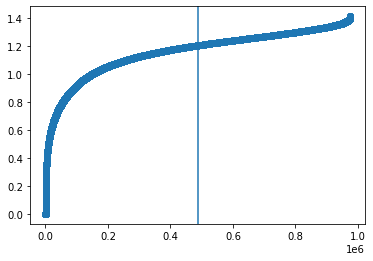

In [394]:
import matplotlib.pyplot as plt

plt.scatter(range(0,987**2), np.sort(ed.flatten()))
plt.axvline(987**2/2)
plt.show()

The euclidean distance among my 987 proteins range from 0 to 1.41, median is about 1.2. If I expect there to be 10-50 clusters within a dataset of 1,000 proteins, then I think my epsilon has got to be much smaller than this median. 

Try different epsilons now.

In [395]:
range_eps = np.linspace(start=0.1, stop=1.0, num=10)

for n in range_eps:
    clustering = DBSCAN(eps=n, min_samples=10).fit(X)
    cluster_labels = clustering.labels_
    
    if len(np.unique(cluster_labels))==1:
        print("eps = " + str(round(n, 2)) + ": Everything is a noise!")
    else:
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("eps = " + str(round(n, 2)) + ":", 
              str(round(silhouette_avg, 4)))

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

eps = 0.1: Everything is a noise!
eps = 0.2: -0.0065
eps = 0.3: -0.1116
eps = 0.4: 0.0274
eps = 0.5: 0.0745
eps = 0.6: 0.1006
eps = 0.7: 0.0621
eps = 0.8: 0.0858
eps = 0.9: 0.0836
eps = 1.0: 0.0923


Now let's try doing a manual grid search. We want to maximize the silouette score.

In [905]:
range_eps = np.linspace(start=0.1, stop=1.0, num=10)
range_min_samples = range(10, 200, 10)

from sklearn.metrics import davies_bouldin_score


def dbscan_gridsearch(X, range_eps, range_min_samples, metric='euclidean'):
    search_results = []
    for i in range_eps:
        for j in range_min_samples:
            clustering = DBSCAN(eps=i, 
                                min_samples=j,
                                metric=metric).fit(X)
            cluster_labels = clustering.labels_

            if len(np.unique(cluster_labels))==1:
                print("eps=" + str(round(i, 2)) + ", min_samples=" + str(j)  
                      + ": Everything is a noise!")
            else:
                sil_sc = silhouette_score(X, cluster_labels)
                db_sc = davies_bouldin_score(X, cluster_labels)
                print("eps=" + str(round(i, 2)) 
                      + " | min_samples=" + str(j) 
                      + " | Silhouette "+ str(round(sil_sc, 4))
                      + " | DB sc "+ str(round(db_sc, 4))
                      + " | noise " + str(sum(cluster_labels==-1))
                      + " | k " + str(len(np.unique(clustering.labels_)))
                      + " | max clus size " + str(np.unique(clustering.labels_, return_counts=True)[1][1:].max())
                     )
                search_results.append(((i, j), sil_sc, db_sc))

    return sorted(search_results, key=lambda x: x[1], reverse=True)



32

In [ ]:
search_results = dbscan_gridsearch(X, range_eps, range_min_samples)

In [408]:
search_results

[((0.6, 10), 0.10062334395122446),
 ((1.0, 180), 0.10019600298927343),
 ((1.0, 90), 0.10008703778391964),
 ((1.0, 170), 0.09996879475275447),
 ((1.0, 160), 0.09994635643362708),
 ((1.0, 190), 0.099843383104516),
 ((1.0, 120), 0.09975458237952906),
 ((1.0, 150), 0.09968969400558335),
 ((0.9, 30), 0.09966479716754044),
 ((1.0, 130), 0.09957527231470707),
 ((1.0, 110), 0.09945751277936156),
 ((1.0, 140), 0.09940835589336891),
 ((1.0, 100), 0.09867890593139018),
 ((1.0, 80), 0.09777008789765693),
 ((1.0, 70), 0.09736258993747669),
 ((1.0, 50), 0.0965156529388127),
 ((0.9, 60), 0.09642652017197094),
 ((0.9, 190), 0.09629273988643941),
 ((0.9, 180), 0.09625210701405415),
 ((0.9, 80), 0.09624053687037468),
 ((1.0, 40), 0.09623713712167237),
 ((1.0, 60), 0.09615374573902442),
 ((0.9, 50), 0.09614604537402098),
 ((0.9, 100), 0.09604364933028252),
 ((0.9, 70), 0.09601265971793706),
 ((0.9, 110), 0.0959877864207942),
 ((0.9, 120), 0.0959877864207942),
 ((0.9, 130), 0.09568807086067671),
 ((0.9, 9

Looks like the winner is: `eps=0.6, min_samples=10`

Now that we have a working grid search of sorts, let's try working on the entire dataset.

# Full dataset

In [633]:
# This is the list of file paths in gcs 
len(keys[1:])

21

In [766]:
missing_full=np.empty((0,1), dtype=str)
X_hold = [] 
protein_name_full=np.empty((0,1), dtype=str)
z=0

for key in keys[1:]:
    # I actually only need the file path once in the right storage.
    key = gcs.uri_to_bucket_and_key(key)[1]
    
    # parse the file 
    X, protein, missing_protein = protein_file_processor(key)
    
    # Put it into list 
    X_hold.append(X)
    protein_name_full = np.append(protein_name_full, protein)
    missing_full = np.append(missing_full, missing_protein)
    
    print(key, "missing", len(missing_protein))
    
# Stack all the X 
X_full = np.vstack(X_hold)

embeddings/DeepFold/embeddings_0.csv missing 14
embeddings/DeepFold/embeddings_1.csv missing 10
embeddings/DeepFold/embeddings_10.csv missing 8
embeddings/DeepFold/embeddings_11.csv missing 9
embeddings/DeepFold/embeddings_12.csv missing 6
embeddings/DeepFold/embeddings_13.csv missing 13
embeddings/DeepFold/embeddings_14.csv missing 16
embeddings/DeepFold/embeddings_15.csv missing 10
embeddings/DeepFold/embeddings_16.csv missing 16
embeddings/DeepFold/embeddings_17.csv missing 9
embeddings/DeepFold/embeddings_18.csv missing 5
embeddings/DeepFold/embeddings_19.csv missing 8
embeddings/DeepFold/embeddings_2.csv missing 11
embeddings/DeepFold/embeddings_20.csv missing 5
embeddings/DeepFold/embeddings_3.csv missing 8
embeddings/DeepFold/embeddings_4.csv missing 10
embeddings/DeepFold/embeddings_5.csv missing 11
embeddings/DeepFold/embeddings_6.csv missing 6
embeddings/DeepFold/embeddings_7.csv missing 13
embeddings/DeepFold/embeddings_8.csv missing 6
embeddings/DeepFold/embeddings_9.csv mi

In [767]:
len(X_hold)

21

In [855]:
X_full.shape

(20301, 398)

In [769]:
protein_name_full.shape

(20301,)

In [770]:
missing_full.shape

(203,)

In [857]:

# Create an empty list
filter_arr = []

# go through each element in arr
for element in X_full:
    # if the element is higher than 42, set the value to True, otherwise False:
#     print(element.shape, sum(element == 0))
    filter_arr.append(sum(element == 0))


(398,) 141
(398,) 194
(398,) 41
(398,) 159
(398,) 169
(398,) 135
(398,) 180
(398,) 330
(398,) 175
(398,) 179
(398,) 197
(398,) 234
(398,) 142
(398,) 167
(398,) 226
(398,) 199
(398,) 5
(398,) 69
(398,) 188
(398,) 172
(398,) 245
(398,) 109
(398,) 271
(398,) 92
(398,) 135
(398,) 152
(398,) 129
(398,) 85
(398,) 170
(398,) 176
(398,) 273
(398,) 191
(398,) 141
(398,) 131
(398,) 30
(398,) 179
(398,) 194
(398,) 196
(398,) 184
(398,) 139
(398,) 12
(398,) 164
(398,) 107
(398,) 140
(398,) 199
(398,) 142
(398,) 200
(398,) 192
(398,) 323
(398,) 167
(398,) 216
(398,) 136
(398,) 84
(398,) 84
(398,) 135
(398,) 337
(398,) 183
(398,) 204
(398,) 125
(398,) 196
(398,) 224
(398,) 226
(398,) 107
(398,) 142
(398,) 51
(398,) 173
(398,) 6
(398,) 168
(398,) 273
(398,) 170
(398,) 22
(398,) 289
(398,) 125
(398,) 247
(398,) 258
(398,) 51
(398,) 157
(398,) 259
(398,) 142
(398,) 141
(398,) 215
(398,) 199
(398,) 138
(398,) 273
(398,) 87
(398,) 224
(398,) 275
(398,) 16
(398,) 103
(398,) 269
(398,) 259
(398,) 119
(398,

(398,) 63
(398,) 99
(398,) 39
(398,) 55
(398,) 110
(398,) 127
(398,) 131
(398,) 63
(398,) 134
(398,) 220
(398,) 197
(398,) 134
(398,) 308
(398,) 224
(398,) 306
(398,) 141
(398,) 116
(398,) 280
(398,) 201
(398,) 175
(398,) 165
(398,) 194
(398,) 204
(398,) 183
(398,) 193
(398,) 132
(398,) 177
(398,) 125
(398,) 184
(398,) 169
(398,) 199
(398,) 157
(398,) 271
(398,) 67
(398,) 240
(398,) 120
(398,) 240
(398,) 258
(398,) 207
(398,) 5
(398,) 142
(398,) 171
(398,) 26
(398,) 180
(398,) 168
(398,) 148
(398,) 157
(398,) 97
(398,) 3
(398,) 208
(398,) 180
(398,) 53
(398,) 286
(398,) 263
(398,) 129
(398,) 79
(398,) 195
(398,) 199
(398,) 234
(398,) 130
(398,) 151
(398,) 92
(398,) 267
(398,) 198
(398,) 48
(398,) 236
(398,) 226
(398,) 139
(398,) 21
(398,) 121
(398,) 228
(398,) 246
(398,) 54
(398,) 197
(398,) 198
(398,) 144
(398,) 137
(398,) 137
(398,) 187
(398,) 50
(398,) 150
(398,) 177
(398,) 72
(398,) 79
(398,) 157
(398,) 214
(398,) 160
(398,) 243
(398,) 204
(398,) 172
(398,) 134
(398,) 275
(398,) 98

(398,) 181
(398,) 171
(398,) 157
(398,) 274
(398,) 157
(398,) 198
(398,) 171
(398,) 267
(398,) 127
(398,) 122
(398,) 247
(398,) 100
(398,) 263
(398,) 114
(398,) 98
(398,) 107
(398,) 157
(398,) 203
(398,) 241
(398,) 150
(398,) 120
(398,) 197
(398,) 158
(398,) 185
(398,) 151
(398,) 102
(398,) 142
(398,) 165
(398,) 77
(398,) 225
(398,) 210
(398,) 142
(398,) 151
(398,) 210
(398,) 116
(398,) 130
(398,) 117
(398,) 205
(398,) 214
(398,) 234
(398,) 188
(398,) 163
(398,) 108
(398,) 273
(398,) 92
(398,) 179
(398,) 191
(398,) 48
(398,) 255
(398,) 88
(398,) 159
(398,) 146
(398,) 105
(398,) 173
(398,) 138
(398,) 260
(398,) 176
(398,) 247
(398,) 219
(398,) 108
(398,) 212
(398,) 237
(398,) 54
(398,) 222
(398,) 156
(398,) 186
(398,) 194
(398,) 184
(398,) 314
(398,) 64
(398,) 233
(398,) 202
(398,) 144
(398,) 238
(398,) 53
(398,) 307
(398,) 184
(398,) 198
(398,) 47
(398,) 4
(398,) 279
(398,) 221
(398,) 279
(398,) 13
(398,) 220
(398,) 107
(398,) 90
(398,) 212
(398,) 76
(398,) 146
(398,) 166
(398,) 95
(39

(398,) 145
(398,) 99
(398,) 223
(398,) 235
(398,) 144
(398,) 159
(398,) 149
(398,) 122
(398,) 150
(398,) 192
(398,) 118
(398,) 136
(398,) 246
(398,) 133
(398,) 151
(398,) 145
(398,) 171
(398,) 192
(398,) 222
(398,) 183
(398,) 174
(398,) 203
(398,) 120
(398,) 143
(398,) 52
(398,) 80
(398,) 338
(398,) 236
(398,) 278
(398,) 143
(398,) 163
(398,) 263
(398,) 137
(398,) 121
(398,) 230
(398,) 216
(398,) 336
(398,) 160
(398,) 109
(398,) 237
(398,) 134
(398,) 160
(398,) 132
(398,) 247
(398,) 286
(398,) 224
(398,) 167
(398,) 116
(398,) 183
(398,) 114
(398,) 169
(398,) 109
(398,) 103
(398,) 255
(398,) 203
(398,) 160
(398,) 174
(398,) 77
(398,) 150
(398,) 200
(398,) 61
(398,) 126
(398,) 194
(398,) 196
(398,) 111
(398,) 56
(398,) 151
(398,) 227
(398,) 97
(398,) 140
(398,) 52
(398,) 89
(398,) 128
(398,) 211
(398,) 165
(398,) 179
(398,) 136
(398,) 156
(398,) 202
(398,) 161
(398,) 225
(398,) 283
(398,) 194
(398,) 257
(398,) 93
(398,) 139
(398,) 153
(398,) 60
(398,) 135
(398,) 197
(398,) 224
(398,) 32


(398,) 171
(398,) 160
(398,) 76
(398,) 159
(398,) 144
(398,) 145
(398,) 231
(398,) 178
(398,) 156
(398,) 172
(398,) 277
(398,) 154
(398,) 112
(398,) 178
(398,) 234
(398,) 254
(398,) 247
(398,) 208
(398,) 187
(398,) 287
(398,) 104
(398,) 147
(398,) 69
(398,) 159
(398,) 214
(398,) 86
(398,) 55
(398,) 275
(398,) 197
(398,) 169
(398,) 147
(398,) 126
(398,) 168
(398,) 136
(398,) 253
(398,) 188
(398,) 114
(398,) 232
(398,) 269
(398,) 250
(398,) 180
(398,) 182
(398,) 310
(398,) 233
(398,) 107
(398,) 85
(398,) 144
(398,) 207
(398,) 145
(398,) 165
(398,) 170
(398,) 237
(398,) 225
(398,) 170
(398,) 155
(398,) 176
(398,) 180
(398,) 68
(398,) 270
(398,) 122
(398,) 231
(398,) 326
(398,) 214
(398,) 271
(398,) 125
(398,) 146
(398,) 45
(398,) 177
(398,) 124
(398,) 37
(398,) 143
(398,) 134
(398,) 174
(398,) 157
(398,) 196
(398,) 36
(398,) 131
(398,) 219
(398,) 198
(398,) 195
(398,) 126
(398,) 155
(398,) 146
(398,) 171
(398,) 121
(398,) 196
(398,) 154
(398,) 121
(398,) 189
(398,) 134
(398,) 267
(398,) 1

(398,) 221
(398,) 107
(398,) 131
(398,) 184
(398,) 169
(398,) 91
(398,) 100
(398,) 207
(398,) 174
(398,) 126
(398,) 242
(398,) 204
(398,) 95
(398,) 217
(398,) 105
(398,) 234
(398,) 63
(398,) 105
(398,) 117
(398,) 147
(398,) 154
(398,) 164
(398,) 186
(398,) 230
(398,) 196
(398,) 324
(398,) 159
(398,) 160
(398,) 185
(398,) 112
(398,) 203
(398,) 195
(398,) 183
(398,) 265
(398,) 165
(398,) 158
(398,) 175
(398,) 218
(398,) 171
(398,) 159
(398,) 117
(398,) 121
(398,) 116
(398,) 83
(398,) 48
(398,) 164
(398,) 147
(398,) 75
(398,) 209
(398,) 134
(398,) 149
(398,) 315
(398,) 220
(398,) 206
(398,) 185
(398,) 124
(398,) 197
(398,) 118
(398,) 118
(398,) 114
(398,) 69
(398,) 104
(398,) 108
(398,) 123
(398,) 139
(398,) 267
(398,) 125
(398,) 173
(398,) 179
(398,) 115
(398,) 191
(398,) 159
(398,) 184
(398,) 203
(398,) 134
(398,) 227
(398,) 166
(398,) 307
(398,) 103
(398,) 122
(398,) 177
(398,) 113
(398,) 125
(398,) 153
(398,) 154
(398,) 194
(398,) 129
(398,) 138
(398,) 211
(398,) 143
(398,) 199
(398,)

(398,) 113
(398,) 142
(398,) 130
(398,) 160
(398,) 154
(398,) 152
(398,) 122
(398,) 121
(398,) 173
(398,) 152
(398,) 127
(398,) 74
(398,) 117
(398,) 178
(398,) 176
(398,) 195
(398,) 224
(398,) 295
(398,) 129
(398,) 196
(398,) 192
(398,) 149
(398,) 125
(398,) 297
(398,) 185
(398,) 128
(398,) 71
(398,) 157
(398,) 245
(398,) 272
(398,) 144
(398,) 56
(398,) 205
(398,) 322
(398,) 139
(398,) 149
(398,) 174
(398,) 257
(398,) 272
(398,) 267
(398,) 138
(398,) 97
(398,) 178
(398,) 255
(398,) 46
(398,) 148
(398,) 155
(398,) 120
(398,) 254
(398,) 176
(398,) 95
(398,) 89
(398,) 138
(398,) 139
(398,) 184
(398,) 158
(398,) 264
(398,) 127
(398,) 197
(398,) 154
(398,) 126
(398,) 171
(398,) 75
(398,) 200
(398,) 240
(398,) 67
(398,) 141
(398,) 206
(398,) 238
(398,) 88
(398,) 242
(398,) 207
(398,) 102
(398,) 209
(398,) 192
(398,) 111
(398,) 237
(398,) 180
(398,) 172
(398,) 147
(398,) 128
(398,) 188
(398,) 237
(398,) 148
(398,) 277
(398,) 153
(398,) 180
(398,) 143
(398,) 176
(398,) 177
(398,) 303
(398,) 13

(398,) 171
(398,) 222
(398,) 150
(398,) 107
(398,) 177
(398,) 92
(398,) 68
(398,) 216
(398,) 223
(398,) 228
(398,) 252
(398,) 80
(398,) 204
(398,) 183
(398,) 118
(398,) 105
(398,) 306
(398,) 64
(398,) 174
(398,) 162
(398,) 198
(398,) 162
(398,) 175
(398,) 83
(398,) 218
(398,) 65
(398,) 270
(398,) 265
(398,) 80
(398,) 245
(398,) 218
(398,) 182
(398,) 135
(398,) 87
(398,) 206
(398,) 156
(398,) 164
(398,) 53
(398,) 240
(398,) 129
(398,) 66
(398,) 88
(398,) 142
(398,) 56
(398,) 101
(398,) 154
(398,) 164
(398,) 109
(398,) 120
(398,) 273
(398,) 314
(398,) 267
(398,) 101
(398,) 180
(398,) 28
(398,) 275
(398,) 183
(398,) 133
(398,) 233
(398,) 219
(398,) 83
(398,) 171
(398,) 220
(398,) 190
(398,) 143
(398,) 154
(398,) 121
(398,) 123
(398,) 276
(398,) 177
(398,) 127
(398,) 215
(398,) 83
(398,) 148
(398,) 192
(398,) 257
(398,) 28
(398,) 289
(398,) 109
(398,) 259
(398,) 215
(398,) 140
(398,) 193
(398,) 174
(398,) 196
(398,) 155
(398,) 270
(398,) 83
(398,) 150
(398,) 289
(398,) 134
(398,) 139
(398,

(398,) 124
(398,) 123
(398,) 137
(398,) 311
(398,) 225
(398,) 164
(398,) 241
(398,) 106
(398,) 154
(398,) 310
(398,) 162
(398,) 120
(398,) 154
(398,) 196
(398,) 204
(398,) 203
(398,) 136
(398,) 96
(398,) 83
(398,) 102
(398,) 120
(398,) 255
(398,) 297
(398,) 181
(398,) 180
(398,) 231
(398,) 191
(398,) 63
(398,) 150
(398,) 122
(398,) 126
(398,) 210
(398,) 103
(398,) 177
(398,) 286
(398,) 181
(398,) 98
(398,) 222
(398,) 132
(398,) 118
(398,) 152
(398,) 167
(398,) 109
(398,) 248
(398,) 248
(398,) 217
(398,) 123
(398,) 180
(398,) 249
(398,) 167
(398,) 116
(398,) 189
(398,) 178
(398,) 168
(398,) 243
(398,) 92
(398,) 173
(398,) 127
(398,) 305
(398,) 275
(398,) 278
(398,) 210
(398,) 177
(398,) 177
(398,) 144
(398,) 150
(398,) 249
(398,) 182
(398,) 183
(398,) 124
(398,) 243
(398,) 182
(398,) 233
(398,) 149
(398,) 187
(398,) 80
(398,) 279
(398,) 59
(398,) 89
(398,) 291
(398,) 265
(398,) 162
(398,) 219
(398,) 259
(398,) 154
(398,) 179
(398,) 112
(398,) 156
(398,) 304
(398,) 143
(398,) 151
(398,) 

(398,) 127
(398,) 60
(398,) 229
(398,) 147
(398,) 307
(398,) 121
(398,) 115
(398,) 262
(398,) 205
(398,) 119
(398,) 214
(398,) 215
(398,) 187
(398,) 102
(398,) 267
(398,) 259
(398,) 126
(398,) 76
(398,) 88
(398,) 266
(398,) 276
(398,) 176
(398,) 146
(398,) 274
(398,) 194
(398,) 207
(398,) 286
(398,) 170
(398,) 241
(398,) 230
(398,) 150
(398,) 258
(398,) 181
(398,) 143
(398,) 71
(398,) 280
(398,) 65
(398,) 244
(398,) 98
(398,) 124
(398,) 307
(398,) 257
(398,) 125
(398,) 230
(398,) 182
(398,) 183
(398,) 74
(398,) 142
(398,) 109
(398,) 96
(398,) 201
(398,) 272
(398,) 80
(398,) 230
(398,) 212
(398,) 245
(398,) 286
(398,) 50
(398,) 290
(398,) 146
(398,) 161
(398,) 188
(398,) 174
(398,) 161
(398,) 202
(398,) 214
(398,) 197
(398,) 133
(398,) 184
(398,) 92
(398,) 188
(398,) 195
(398,) 217
(398,) 307
(398,) 185
(398,) 153
(398,) 118
(398,) 113
(398,) 85
(398,) 158
(398,) 135
(398,) 237
(398,) 117
(398,) 180
(398,) 160
(398,) 138
(398,) 73
(398,) 147
(398,) 43
(398,) 113
(398,) 230
(398,) 70
(39

(398,) 167
(398,) 216
(398,) 164
(398,) 120
(398,) 167
(398,) 127
(398,) 138
(398,) 124
(398,) 112
(398,) 134
(398,) 288
(398,) 233
(398,) 201
(398,) 115
(398,) 68
(398,) 197
(398,) 124
(398,) 127
(398,) 194
(398,) 209
(398,) 123
(398,) 232
(398,) 311
(398,) 210
(398,) 157
(398,) 134
(398,) 247
(398,) 143
(398,) 221
(398,) 273
(398,) 291
(398,) 206
(398,) 97
(398,) 311
(398,) 193
(398,) 185
(398,) 156
(398,) 110
(398,) 90
(398,) 119
(398,) 99
(398,) 284
(398,) 109
(398,) 175
(398,) 81
(398,) 97
(398,) 173
(398,) 140
(398,) 174
(398,) 144
(398,) 197
(398,) 174
(398,) 186
(398,) 83
(398,) 192
(398,) 264
(398,) 200
(398,) 129
(398,) 272
(398,) 146
(398,) 45
(398,) 89
(398,) 149
(398,) 214
(398,) 244
(398,) 238
(398,) 199
(398,) 178
(398,) 160
(398,) 203
(398,) 159
(398,) 188
(398,) 152
(398,) 311
(398,) 199
(398,) 135
(398,) 239
(398,) 296
(398,) 192
(398,) 217
(398,) 136
(398,) 131
(398,) 204
(398,) 151
(398,) 186
(398,) 128
(398,) 230
(398,) 160
(398,) 90
(398,) 238
(398,) 103
(398,) 18

(398,) 201
(398,) 126
(398,) 109
(398,) 106
(398,) 159
(398,) 97
(398,) 118
(398,) 104
(398,) 176
(398,) 38
(398,) 248
(398,) 32
(398,) 146
(398,) 221
(398,) 91
(398,) 146
(398,) 180
(398,) 126
(398,) 105
(398,) 155
(398,) 171
(398,) 259
(398,) 165
(398,) 160
(398,) 297
(398,) 161
(398,) 269
(398,) 187
(398,) 165
(398,) 167
(398,) 158
(398,) 219
(398,) 133
(398,) 98
(398,) 212
(398,) 147
(398,) 148
(398,) 209
(398,) 265
(398,) 89
(398,) 114
(398,) 191
(398,) 68
(398,) 142
(398,) 160
(398,) 328
(398,) 135
(398,) 100
(398,) 117
(398,) 153
(398,) 130
(398,) 87
(398,) 112
(398,) 154
(398,) 149
(398,) 77
(398,) 185
(398,) 181
(398,) 169
(398,) 121
(398,) 190
(398,) 315
(398,) 204
(398,) 216
(398,) 145
(398,) 179
(398,) 266
(398,) 143
(398,) 57
(398,) 212
(398,) 157
(398,) 219
(398,) 158
(398,) 290
(398,) 94
(398,) 98
(398,) 229
(398,) 160
(398,) 143
(398,) 161
(398,) 138
(398,) 137
(398,) 54
(398,) 192
(398,) 213
(398,) 238
(398,) 272
(398,) 242
(398,) 104
(398,) 306
(398,) 198
(398,) 91
(3

(398,) 243
(398,) 198
(398,) 192
(398,) 146
(398,) 188
(398,) 149
(398,) 119
(398,) 274
(398,) 166
(398,) 159
(398,) 87
(398,) 28
(398,) 98
(398,) 117
(398,) 265
(398,) 258
(398,) 203
(398,) 67
(398,) 156
(398,) 113
(398,) 116
(398,) 78
(398,) 210
(398,) 172
(398,) 145
(398,) 237
(398,) 170
(398,) 123
(398,) 303
(398,) 183
(398,) 220
(398,) 159
(398,) 162
(398,) 195
(398,) 162
(398,) 152
(398,) 195
(398,) 133
(398,) 190
(398,) 120
(398,) 303
(398,) 187
(398,) 171
(398,) 160
(398,) 129
(398,) 129
(398,) 86
(398,) 127
(398,) 248
(398,) 170
(398,) 30
(398,) 148
(398,) 129
(398,) 153
(398,) 168
(398,) 145
(398,) 114
(398,) 78
(398,) 119
(398,) 178
(398,) 204
(398,) 305
(398,) 158
(398,) 150
(398,) 137
(398,) 87
(398,) 200
(398,) 91
(398,) 89
(398,) 257
(398,) 151
(398,) 72
(398,) 114
(398,) 184
(398,) 270
(398,) 244
(398,) 264
(398,) 169
(398,) 134
(398,) 266
(398,) 175
(398,) 260
(398,) 117
(398,) 144
(398,) 171
(398,) 252
(398,) 230
(398,) 129
(398,) 173
(398,) 120
(398,) 76
(398,) 105
(

(398,) 247
(398,) 249
(398,) 109
(398,) 280
(398,) 143
(398,) 186
(398,) 202
(398,) 224
(398,) 195
(398,) 142
(398,) 122
(398,) 74
(398,) 127
(398,) 136
(398,) 225
(398,) 197
(398,) 88
(398,) 141
(398,) 133
(398,) 276
(398,) 100
(398,) 285
(398,) 165
(398,) 176
(398,) 138
(398,) 290
(398,) 222
(398,) 104
(398,) 194
(398,) 110
(398,) 127
(398,) 181
(398,) 212
(398,) 103
(398,) 289
(398,) 296
(398,) 83
(398,) 57
(398,) 116
(398,) 191
(398,) 134
(398,) 176
(398,) 81
(398,) 195
(398,) 188
(398,) 187
(398,) 188
(398,) 25
(398,) 147
(398,) 140
(398,) 139
(398,) 152
(398,) 112
(398,) 192
(398,) 285
(398,) 109
(398,) 158
(398,) 298
(398,) 120
(398,) 179
(398,) 279
(398,) 165
(398,) 214
(398,) 239
(398,) 156
(398,) 110
(398,) 127
(398,) 240
(398,) 200
(398,) 101
(398,) 163
(398,) 239
(398,) 43
(398,) 106
(398,) 283
(398,) 114
(398,) 188
(398,) 176
(398,) 219
(398,) 144
(398,) 290
(398,) 138
(398,) 239
(398,) 142
(398,) 217
(398,) 203
(398,) 277
(398,) 276
(398,) 242
(398,) 192
(398,) 120
(398,)

(398,) 87
(398,) 59
(398,) 121
(398,) 195
(398,) 246
(398,) 155
(398,) 122
(398,) 155
(398,) 193
(398,) 142
(398,) 153
(398,) 157
(398,) 162
(398,) 142
(398,) 131
(398,) 175
(398,) 50
(398,) 247
(398,) 97
(398,) 150
(398,) 63
(398,) 155
(398,) 199
(398,) 157
(398,) 108
(398,) 250
(398,) 168
(398,) 62
(398,) 205
(398,) 245
(398,) 177
(398,) 215
(398,) 71
(398,) 164
(398,) 115
(398,) 234
(398,) 173
(398,) 137
(398,) 133
(398,) 204
(398,) 284
(398,) 109
(398,) 102
(398,) 119
(398,) 260
(398,) 208
(398,) 275
(398,) 260
(398,) 140
(398,) 137
(398,) 88
(398,) 260
(398,) 208
(398,) 208
(398,) 195
(398,) 202
(398,) 164
(398,) 184
(398,) 128
(398,) 100
(398,) 102
(398,) 161
(398,) 158
(398,) 154
(398,) 188
(398,) 177
(398,) 149
(398,) 98
(398,) 104
(398,) 201
(398,) 100
(398,) 143
(398,) 164
(398,) 67
(398,) 150
(398,) 223
(398,) 241
(398,) 113
(398,) 72
(398,) 216
(398,) 186
(398,) 89
(398,) 146
(398,) 78
(398,) 127
(398,) 256
(398,) 161
(398,) 164
(398,) 229
(398,) 177
(398,) 207
(398,) 179
(

(398,) 64
(398,) 248
(398,) 145
(398,) 129
(398,) 32
(398,) 206
(398,) 204
(398,) 64
(398,) 71
(398,) 308
(398,) 137
(398,) 153
(398,) 115
(398,) 169
(398,) 264
(398,) 114
(398,) 138
(398,) 134
(398,) 87
(398,) 29
(398,) 183
(398,) 174
(398,) 7
(398,) 166
(398,) 136
(398,) 71
(398,) 166
(398,) 249
(398,) 220
(398,) 177
(398,) 270
(398,) 135
(398,) 75
(398,) 112
(398,) 115
(398,) 151
(398,) 270
(398,) 194
(398,) 191
(398,) 129
(398,) 178
(398,) 266
(398,) 172
(398,) 147
(398,) 83
(398,) 176
(398,) 192
(398,) 227
(398,) 154
(398,) 81
(398,) 120
(398,) 194
(398,) 173
(398,) 241
(398,) 161
(398,) 279
(398,) 272
(398,) 169
(398,) 191
(398,) 275
(398,) 296
(398,) 182
(398,) 34
(398,) 155
(398,) 158
(398,) 194
(398,) 123
(398,) 141
(398,) 82
(398,) 158
(398,) 203
(398,) 93
(398,) 161
(398,) 158
(398,) 154
(398,) 89
(398,) 249
(398,) 172
(398,) 28
(398,) 79
(398,) 31
(398,) 172
(398,) 310
(398,) 116
(398,) 178
(398,) 114
(398,) 127
(398,) 139
(398,) 175
(398,) 27
(398,) 219
(398,) 169
(398,) 2

(398,) 222
(398,) 188
(398,) 139
(398,) 178
(398,) 142
(398,) 145
(398,) 191
(398,) 167
(398,) 256
(398,) 208
(398,) 264
(398,) 266
(398,) 92
(398,) 136
(398,) 312
(398,) 198
(398,) 167
(398,) 221
(398,) 250
(398,) 187
(398,) 157
(398,) 170
(398,) 225
(398,) 48
(398,) 231
(398,) 298
(398,) 138
(398,) 145
(398,) 160
(398,) 170
(398,) 124
(398,) 116
(398,) 145
(398,) 239
(398,) 164
(398,) 240
(398,) 190
(398,) 120
(398,) 155
(398,) 103
(398,) 277
(398,) 178
(398,) 146
(398,) 299
(398,) 271
(398,) 170
(398,) 48
(398,) 81
(398,) 227
(398,) 282
(398,) 239
(398,) 82
(398,) 88
(398,) 51
(398,) 178
(398,) 102
(398,) 140
(398,) 30
(398,) 298
(398,) 110
(398,) 180
(398,) 260
(398,) 85
(398,) 179
(398,) 177
(398,) 118
(398,) 199
(398,) 167
(398,) 181
(398,) 239
(398,) 300
(398,) 158
(398,) 116
(398,) 226
(398,) 117
(398,) 277
(398,) 171
(398,) 111
(398,) 228
(398,) 168
(398,) 133
(398,) 233
(398,) 60
(398,) 195
(398,) 206
(398,) 283
(398,) 266
(398,) 205
(398,) 234
(398,) 153
(398,) 181
(398,) 27

(398,) 140
(398,) 181
(398,) 246
(398,) 135
(398,) 135
(398,) 193
(398,) 209
(398,) 227
(398,) 311
(398,) 249
(398,) 184
(398,) 94
(398,) 205
(398,) 257
(398,) 112
(398,) 94
(398,) 190
(398,) 107
(398,) 185
(398,) 213
(398,) 309
(398,) 191
(398,) 305
(398,) 165
(398,) 158
(398,) 219
(398,) 208
(398,) 209
(398,) 115
(398,) 186
(398,) 139
(398,) 162
(398,) 152
(398,) 116
(398,) 263
(398,) 182
(398,) 196
(398,) 214
(398,) 92
(398,) 117
(398,) 195
(398,) 95
(398,) 134
(398,) 308
(398,) 216
(398,) 240
(398,) 172
(398,) 148
(398,) 165
(398,) 170
(398,) 179
(398,) 185
(398,) 99
(398,) 196
(398,) 251
(398,) 91
(398,) 142
(398,) 168
(398,) 218
(398,) 185
(398,) 182
(398,) 84
(398,) 274
(398,) 247
(398,) 153
(398,) 100
(398,) 115
(398,) 110
(398,) 163
(398,) 126
(398,) 234
(398,) 321
(398,) 196
(398,) 322
(398,) 212
(398,) 193
(398,) 188
(398,) 217
(398,) 276
(398,) 261
(398,) 127
(398,) 155
(398,) 256
(398,) 118
(398,) 90
(398,) 169
(398,) 126
(398,) 105
(398,) 188
(398,) 238
(398,) 191
(398,) 

(398,) 182
(398,) 130
(398,) 125
(398,) 317
(398,) 131
(398,) 160
(398,) 75
(398,) 131
(398,) 252
(398,) 192
(398,) 170
(398,) 130
(398,) 262
(398,) 329
(398,) 164
(398,) 51
(398,) 259
(398,) 330
(398,) 217
(398,) 51
(398,) 186
(398,) 77
(398,) 149
(398,) 241
(398,) 73
(398,) 188
(398,) 180
(398,) 61
(398,) 81
(398,) 61
(398,) 120
(398,) 171
(398,) 63
(398,) 123
(398,) 85
(398,) 181
(398,) 120
(398,) 137
(398,) 174
(398,) 253
(398,) 267
(398,) 61
(398,) 274
(398,) 45
(398,) 149
(398,) 107
(398,) 247
(398,) 128
(398,) 158
(398,) 83
(398,) 265
(398,) 188
(398,) 143
(398,) 101
(398,) 201
(398,) 201
(398,) 172
(398,) 137
(398,) 249
(398,) 126
(398,) 110
(398,) 196
(398,) 126
(398,) 225
(398,) 184
(398,) 56
(398,) 208
(398,) 236
(398,) 105
(398,) 268
(398,) 125
(398,) 92
(398,) 141
(398,) 132
(398,) 241
(398,) 298
(398,) 199
(398,) 137
(398,) 194
(398,) 108
(398,) 198
(398,) 113
(398,) 197
(398,) 108
(398,) 180
(398,) 168
(398,) 47
(398,) 136
(398,) 119
(398,) 149
(398,) 142
(398,) 82
(398,

(398,) 156
(398,) 229
(398,) 202
(398,) 186
(398,) 148
(398,) 177
(398,) 232
(398,) 133
(398,) 242
(398,) 97
(398,) 79
(398,) 316
(398,) 145
(398,) 149
(398,) 171
(398,) 153
(398,) 169
(398,) 188
(398,) 221
(398,) 99
(398,) 166
(398,) 158
(398,) 129
(398,) 191
(398,) 187
(398,) 188
(398,) 172
(398,) 266
(398,) 219
(398,) 127
(398,) 271
(398,) 170
(398,) 188
(398,) 135
(398,) 166
(398,) 171
(398,) 183
(398,) 128
(398,) 176
(398,) 186
(398,) 143
(398,) 74
(398,) 125
(398,) 257
(398,) 64
(398,) 130
(398,) 91
(398,) 196
(398,) 88
(398,) 191
(398,) 197
(398,) 186
(398,) 150
(398,) 177
(398,) 133
(398,) 238
(398,) 231
(398,) 193
(398,) 249
(398,) 294
(398,) 87
(398,) 197
(398,) 139
(398,) 103
(398,) 310
(398,) 105
(398,) 75
(398,) 179
(398,) 86
(398,) 132
(398,) 38
(398,) 130
(398,) 191
(398,) 267
(398,) 269
(398,) 275
(398,) 312
(398,) 321
(398,) 322
(398,) 192
(398,) 222
(398,) 231
(398,) 130
(398,) 199
(398,) 53
(398,) 176
(398,) 245
(398,) 129
(398,) 156
(398,) 217
(398,) 176
(398,) 201


(398,) 105
(398,) 98
(398,) 126
(398,) 76
(398,) 173
(398,) 244
(398,) 179
(398,) 124
(398,) 133
(398,) 82
(398,) 189
(398,) 128
(398,) 257
(398,) 196
(398,) 56
(398,) 84
(398,) 206
(398,) 86
(398,) 247
(398,) 263
(398,) 187
(398,) 229
(398,) 120
(398,) 139
(398,) 183
(398,) 137
(398,) 216
(398,) 146
(398,) 304
(398,) 178
(398,) 104
(398,) 132
(398,) 104
(398,) 134
(398,) 107
(398,) 174
(398,) 157
(398,) 131
(398,) 173
(398,) 118
(398,) 154
(398,) 102
(398,) 147
(398,) 162
(398,) 192
(398,) 65
(398,) 95
(398,) 127
(398,) 236
(398,) 69
(398,) 245
(398,) 159
(398,) 83
(398,) 264
(398,) 185
(398,) 102
(398,) 123
(398,) 215
(398,) 141
(398,) 174
(398,) 261
(398,) 127
(398,) 182
(398,) 97
(398,) 177
(398,) 209
(398,) 151
(398,) 261
(398,) 180
(398,) 119
(398,) 232
(398,) 303
(398,) 150
(398,) 118
(398,) 212
(398,) 94
(398,) 166
(398,) 119
(398,) 126
(398,) 305
(398,) 117
(398,) 151
(398,) 136
(398,) 71
(398,) 82
(398,) 204
(398,) 158
(398,) 109
(398,) 179
(398,) 272
(398,) 195
(398,) 166
(3

(398,) 158
(398,) 121
(398,) 123
(398,) 261
(398,) 164
(398,) 121
(398,) 206
(398,) 138
(398,) 186
(398,) 164
(398,) 298
(398,) 134
(398,) 254
(398,) 139
(398,) 96
(398,) 90
(398,) 162
(398,) 170
(398,) 121
(398,) 63
(398,) 141
(398,) 122
(398,) 120
(398,) 214
(398,) 139
(398,) 154
(398,) 161
(398,) 157
(398,) 162
(398,) 270
(398,) 201
(398,) 238
(398,) 255
(398,) 43
(398,) 183
(398,) 48
(398,) 78
(398,) 182
(398,) 173
(398,) 302
(398,) 176
(398,) 157
(398,) 89
(398,) 186
(398,) 52
(398,) 142
(398,) 285
(398,) 269
(398,) 114
(398,) 164
(398,) 71
(398,) 225
(398,) 136
(398,) 182
(398,) 189
(398,) 158
(398,) 240
(398,) 239
(398,) 247
(398,) 163
(398,) 104
(398,) 182
(398,) 66
(398,) 124
(398,) 66
(398,) 124
(398,) 272
(398,) 226
(398,) 169
(398,) 145
(398,) 226
(398,) 218
(398,) 305
(398,) 221
(398,) 244
(398,) 226
(398,) 289
(398,) 185
(398,) 173
(398,) 111
(398,) 176
(398,) 190
(398,) 197
(398,) 132
(398,) 231
(398,) 62
(398,) 127
(398,) 251
(398,) 112
(398,) 113
(398,) 125
(398,) 280


(398,) 182
(398,) 156
(398,) 262
(398,) 185
(398,) 178
(398,) 76
(398,) 248
(398,) 176
(398,) 254
(398,) 72
(398,) 54
(398,) 251
(398,) 258
(398,) 196
(398,) 51
(398,) 213
(398,) 54
(398,) 232
(398,) 193
(398,) 247
(398,) 154
(398,) 266
(398,) 192
(398,) 101
(398,) 251
(398,) 244
(398,) 178
(398,) 112
(398,) 197
(398,) 243
(398,) 184
(398,) 285
(398,) 233
(398,) 152
(398,) 135
(398,) 115
(398,) 200
(398,) 98
(398,) 306
(398,) 158
(398,) 193
(398,) 251
(398,) 108
(398,) 95
(398,) 136
(398,) 126
(398,) 156
(398,) 141
(398,) 203
(398,) 170
(398,) 172
(398,) 44
(398,) 113
(398,) 91
(398,) 190
(398,) 268
(398,) 166
(398,) 92
(398,) 166
(398,) 174
(398,) 136
(398,) 219
(398,) 102
(398,) 161
(398,) 98
(398,) 61
(398,) 261
(398,) 244
(398,) 259
(398,) 331
(398,) 183
(398,) 184
(398,) 261
(398,) 201
(398,) 273
(398,) 306
(398,) 169
(398,) 209
(398,) 169
(398,) 263
(398,) 97
(398,) 273
(398,) 158
(398,) 187
(398,) 233
(398,) 148
(398,) 74
(398,) 187
(398,) 279
(398,) 171
(398,) 235
(398,) 238
(3

(398,) 236
(398,) 81
(398,) 271
(398,) 227
(398,) 195
(398,) 301
(398,) 209
(398,) 47
(398,) 134
(398,) 127
(398,) 133
(398,) 264
(398,) 127
(398,) 98
(398,) 211
(398,) 216
(398,) 185
(398,) 167
(398,) 124
(398,) 218
(398,) 282
(398,) 249
(398,) 180
(398,) 70
(398,) 236
(398,) 224
(398,) 227
(398,) 115
(398,) 251
(398,) 133
(398,) 223
(398,) 166
(398,) 135
(398,) 197
(398,) 228
(398,) 82
(398,) 201
(398,) 95
(398,) 223
(398,) 293
(398,) 199
(398,) 157
(398,) 99
(398,) 193
(398,) 231
(398,) 200
(398,) 253
(398,) 69
(398,) 86
(398,) 90
(398,) 250
(398,) 170
(398,) 70
(398,) 231
(398,) 99
(398,) 69
(398,) 153
(398,) 162
(398,) 157
(398,) 166
(398,) 86
(398,) 179
(398,) 258
(398,) 70
(398,) 259
(398,) 116
(398,) 60
(398,) 115
(398,) 128
(398,) 71
(398,) 229
(398,) 150
(398,) 54
(398,) 154
(398,) 191
(398,) 193
(398,) 103
(398,) 113
(398,) 148
(398,) 173
(398,) 182
(398,) 80
(398,) 209
(398,) 302
(398,) 115
(398,) 166
(398,) 171
(398,) 140
(398,) 181
(398,) 258
(398,) 249
(398,) 274
(398,) 

(398,) 251
(398,) 113
(398,) 277
(398,) 159
(398,) 115
(398,) 139
(398,) 105
(398,) 179
(398,) 210
(398,) 198
(398,) 138
(398,) 126
(398,) 168
(398,) 151
(398,) 213
(398,) 137
(398,) 198
(398,) 266
(398,) 145
(398,) 134
(398,) 162
(398,) 233
(398,) 142
(398,) 94
(398,) 245
(398,) 144
(398,) 119
(398,) 294
(398,) 253
(398,) 155
(398,) 196
(398,) 288
(398,) 162
(398,) 154
(398,) 68
(398,) 241
(398,) 230
(398,) 239
(398,) 254
(398,) 157
(398,) 125
(398,) 175
(398,) 258
(398,) 154
(398,) 151
(398,) 186
(398,) 151
(398,) 76
(398,) 175
(398,) 257
(398,) 143
(398,) 105
(398,) 182
(398,) 237
(398,) 84
(398,) 177
(398,) 279
(398,) 167
(398,) 192
(398,) 190
(398,) 96
(398,) 236
(398,) 83
(398,) 182
(398,) 195
(398,) 269
(398,) 120
(398,) 238
(398,) 142
(398,) 144
(398,) 149
(398,) 110
(398,) 109
(398,) 189
(398,) 84
(398,) 240
(398,) 122
(398,) 257
(398,) 167
(398,) 191
(398,) 126
(398,) 172
(398,) 199
(398,) 175
(398,) 114
(398,) 190
(398,) 138
(398,) 166
(398,) 142
(398,) 292
(398,) 77
(398,) 

In [910]:

# Create an empty list
filter_arr = []

# go through each element in arr
for element in X_full:
    # if the element is higher than 42, set the value to True, otherwise False:
#     print(element.shape, sum(element == 0))
    filter_arr.append(sum(element < 0))


In [911]:
[x for x in filter_arr if x > 0 ]

[]

In [858]:
np.mean(filter_arr)

169.71296980444313

## Cluster full data

In [715]:
ed = euclidean_distances(X_full, X_full)
ed.shape

(20301, 20301)

In [716]:
min_ed = np.min(ed)
max_ed = np.max(ed)
median_ed = np.median(ed)

print(min_ed, max_ed, median_ed)

0.0 1.413966410491882 1.1221421372670195


In [717]:
ed_flatten = ed.flatten()

In [718]:
ed_flatten.shape

(412130601,)

In [719]:
sample_ed = np.random.choice(ed_flatten, 10000)

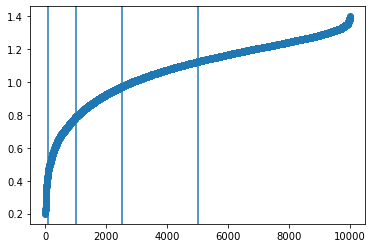

In [720]:
plt.scatter(range(len(sample_ed)), np.sort(sample_ed))
plt.axvline(len(sample_ed)/2)
plt.axvline(len(sample_ed)/4)
plt.axvline(len(sample_ed)/10)
plt.axvline(len(sample_ed)/100)
plt.show()

In [722]:
range_eps = np.linspace(start=0.01, stop=0.4, num=5)
range_min_samples = [10, 20, 50]

search_results = dbscan_gridsearch(X_full, range_eps, range_min_samples)

eps=0.01 | min_samples=10 | Silhouette 0.0302 | DB sc0.9076
eps=0.01, min_samples=20: Everything is a noise!
eps=0.01, min_samples=50: Everything is a noise!
eps=0.11 | min_samples=10 | Silhouette -0.2743 | DB sc1.0956
eps=0.11 | min_samples=20 | Silhouette -0.1712 | DB sc1.2291
eps=0.11 | min_samples=50 | Silhouette -0.094 | DB sc1.2608
eps=0.2 | min_samples=10 | Silhouette -0.2358 | DB sc1.1521
eps=0.2 | min_samples=20 | Silhouette -0.1864 | DB sc1.1703
eps=0.2 | min_samples=50 | Silhouette -0.1552 | DB sc1.2942
eps=0.3 | min_samples=10 | Silhouette -0.201 | DB sc1.3
eps=0.3 | min_samples=20 | Silhouette -0.1209 | DB sc1.3759
eps=0.3 | min_samples=50 | Silhouette -0.0672 | DB sc1.7609
eps=0.4 | min_samples=10 | Silhouette -0.1602 | DB sc1.4666
eps=0.4 | min_samples=20 | Silhouette -0.0135 | DB sc1.729
eps=0.4 | min_samples=50 | Silhouette 0.0251 | DB sc1.7484


In [723]:
range_eps = np.linspace(start=0.01, stop=0.1, num=3)
range_min_samples = [5, 10, 20, 50]

search_results = dbscan_gridsearch(X_full, range_eps, range_min_samples)

eps=0.01 | min_samples=5 | Silhouette 0.0304 | DB sc0.908
eps=0.01 | min_samples=10 | Silhouette 0.0302 | DB sc0.9076
eps=0.01, min_samples=20: Everything is a noise!
eps=0.01, min_samples=50: Everything is a noise!
eps=0.06 | min_samples=5 | Silhouette -0.3173 | DB sc1.0198
eps=0.06 | min_samples=10 | Silhouette -0.2172 | DB sc0.9668
eps=0.06, min_samples=20: Everything is a noise!
eps=0.06, min_samples=50: Everything is a noise!
eps=0.1 | min_samples=5 | Silhouette -0.309 | DB sc1.0028
eps=0.1 | min_samples=10 | Silhouette -0.2753 | DB sc1.083
eps=0.1 | min_samples=20 | Silhouette -0.176 | DB sc1.2115
eps=0.1 | min_samples=50 | Silhouette -0.0981 | DB sc1.2471


In [724]:
# At first, the grid search tried to tell me eps=0.6 was good
clustering = DBSCAN(eps=0.6, min_samples=25).fit(X_full)

In [725]:
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1  6142]
 [    0 13724]
 [    1   133]
 [    2   253]
 [    3    49]]


Oh no, the epsilon is too generous. So I ran grid search again but limited eps to 0.4. Anything below that would give me only negative Silhouette scores.

In [728]:
clustering = DBSCAN(eps=0.4, min_samples=20).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1 11906]
 [    0  6992]
 [    1   268]
 [    2   288]
 [    3   295]
 [    4   215]
 [    5    72]
 [    6    38]
 [    7    79]
 [    8    20]
 [    9    86]
 [   10    21]
 [   11    21]]


The cluster sizes look OK now, but almost half the proteins are considered noise, and 40% are in cluster index 0.

In [729]:
clustering = DBSCAN(eps=0.5, min_samples=10).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1  7832]
 [    0 11527]
 [    1    12]
 [    2    19]
 [    3    20]
 [    4    12]
 [    5    15]
 [    6   245]
 [    7    19]
 [    8    11]
 [    9    20]
 [   10    11]
 [   11    11]
 [   12   120]
 [   13    12]
 [   14    21]
 [   15    15]
 [   16    10]
 [   17    41]
 [   18     9]
 [   19    10]
 [   20    18]
 [   21    22]
 [   22    18]
 [   23    28]
 [   24    13]
 [   25    21]
 [   26    15]
 [   27    16]
 [   28    18]
 [   29    13]
 [   30    15]
 [   31    11]
 [   32    11]
 [   33    12]
 [   34    16]
 [   35    19]
 [   36    14]
 [   37    12]
 [   38    10]
 [   39     7]]


Even 0.5 is too generous for an epsilon. See how big cluster 0 is!

In [730]:
# So I guess eps=0.4 it is. 
clustering = DBSCAN(eps=0.40, min_samples=5).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[  -1 9999]
 [   0 8790]
 [   1   12]
 [   2   15]
 [   3   19]
 [   4    5]
 [   5    6]
 [   6    8]
 [   7   41]
 [   8   15]
 [   9    9]
 [  10  234]
 [  11    5]
 [  12   15]
 [  13   39]
 [  14   10]
 [  15    4]
 [  16   16]
 [  17   10]
 [  18   11]
 [  19    6]
 [  20    5]
 [  21   98]
 [  22    7]
 [  23    9]
 [  24   12]
 [  25   20]
 [  26    9]
 [  27    5]
 [  28    8]
 [  29    5]
 [  30   71]
 [  31    7]
 [  32    6]
 [  33    5]
 [  34    8]
 [  35    9]
 [  36    7]
 [  37   10]
 [  38    9]
 [  39    6]
 [  40   16]
 [  41   22]
 [  42    5]
 [  43   18]
 [  44    6]
 [  45    5]
 [  46    5]
 [  47   35]
 [  48   11]
 [  49   17]
 [  50   11]
 [  51    7]
 [  52    7]
 [  53    6]
 [  54    6]
 [  55    6]
 [  56    5]
 [  57    6]
 [  58    9]
 [  59    6]
 [  60    7]
 [  61   10]
 [  62    7]
 [  63    6]
 [  64    6]
 [  65   13]
 [  66   13]
 [  67    5]
 [  68    7]
 [  69    7]
 [  70    5]
 [  71    8]
 [  72    5]
 [  73    5]
 [  74    6]
 [  75    9]

Still almost half of the points are considered noise. Can I reduce it if I lower the min_samples param?

In [731]:
clustering = DBSCAN(eps=0.40, min_samples=2).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[  -1 7450]
 [   0 9026]
 [   1    2]
 ...
 [1091    2]
 [1092    2]
 [1093    2]]


So the noise went down somewhat, but still substantial. And cluster 0 is still too big.



In [586]:
range_eps = np.linspace(start=0.01, stop=0.4, num=5)
range_min_samples = [6, 10, 20, 50]

search_results = dbscan_gridsearch(X_full, range_eps, range_min_samples)

eps=0.01, min_samples=6: 0.8989
eps=0.01, min_samples=10: 0.8984
eps=0.01, min_samples=20: Everything is a noise!
eps=0.01, min_samples=50: Everything is a noise!
eps=0.05, min_samples=6: 0.9951
eps=0.05, min_samples=10: 0.9808
eps=0.05, min_samples=20: 0.9988
eps=0.05, min_samples=50: Everything is a noise!
eps=0.1, min_samples=6: 1.0155
eps=0.1, min_samples=10: 1.0012
eps=0.1, min_samples=20: 1.2122
eps=0.1, min_samples=50: 1.1999
eps=0.14, min_samples=6: 1.0308
eps=0.14, min_samples=10: 1.0068
eps=0.14, min_samples=20: 1.1046
eps=0.14, min_samples=50: 1.1522
eps=0.18, min_samples=6: 1.0937
eps=0.18, min_samples=10: 1.0704
eps=0.18, min_samples=20: 1.0905
eps=0.18, min_samples=50: 1.2035
eps=0.23, min_samples=6: 1.1513
eps=0.23, min_samples=10: 1.1714
eps=0.23, min_samples=20: 1.2384
eps=0.23, min_samples=50: 1.2159
eps=0.27, min_samples=6: 1.1877
eps=0.27, min_samples=10: 1.187
eps=0.27, min_samples=20: 1.2673
eps=0.27, min_samples=50: 1.663
eps=0.31, min_samples=6: 1.2364
eps=0.31,

# Refinement

To try
Next things to try:
1. Reduce dimensionality of DeepFold embeddings to 100
2. Incorporate BLAST and see what it says about clusters
3. When RMSD & TM score are ready then incorporate them to see what they say about clusters
4. Save model & results (some form of pipeline) 

In [732]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=100)
print("X_full orig shape", X_full.shape)
X_transformed = embedding.fit_transform(X_full)
print("X_transformed new shape", X_transformed.shape)

X_full orig shape (20301, 398)
X_transformed new shape (20301, 100)


In [733]:
print("db score", davies_bouldin_score(X_transformed, clustering.labels_))
print("silhouette score", silhouette_score(X_transformed, clustering.labels_))

clustering = DBSCAN(eps=0.40, min_samples=5).fit(X_transformed)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

db score 1.239694043783252
silhouette score -0.36896264426309094
[[   -1 16805]
 [    0    82]
 [    1   313]
 [    2    18]
 [    3    12]
 [    4   651]
 [    5     6]
 [    6    51]
 [    7   791]
 [    8    23]
 [    9    14]
 [   10    20]
 [   11     6]
 [   12     6]
 [   13    30]
 [   14    13]
 [   15     5]
 [   16     7]
 [   17     5]
 [   18     7]
 [   19    34]
 [   20    11]
 [   21     9]
 [   22    51]
 [   23    12]
 [   24    41]
 [   25    66]
 [   26    28]
 [   27    11]
 [   28     6]
 [   29     6]
 [   30    10]
 [   31    11]
 [   32    12]
 [   33     9]
 [   34    21]
 [   35     8]
 [   36     5]
 [   37     9]
 [   38    16]
 [   39    12]
 [   40    24]
 [   41    45]
 [   42     6]
 [   43     8]
 [   44     6]
 [   45     8]
 [   46    13]
 [   47    11]
 [   48    27]
 [   49     6]
 [   50     5]
 [   51    12]
 [   52    26]
 [   53    11]
 [   54     5]
 [   55     9]
 [   56    11]
 [   57     9]
 [   58    14]
 [   59     7]
 [   60    11]
 [   

In [734]:
import bz2
import pickle

filename='DeepFold_100'
# outfile = open(filename,'wb')
outfile = bz2.BZ2File(filename, 'w')
pickle.dump(X_transformed,outfile)
outfile.close()

In [735]:
range_eps = np.linspace(start=0.01, stop=0.4, num=3)
range_min_samples = [6, 10, 20, 50]

search_results = dbscan_gridsearch(X_transformed, range_eps, range_min_samples)

eps=0.01 | min_samples=6 | Silhouette -0.0314 | DB sc0.959
eps=0.01 | min_samples=10 | Silhouette -0.0303 | DB sc1.0896
eps=0.01 | min_samples=20 | Silhouette -0.0303 | DB sc1.0896
eps=0.01, min_samples=50: Everything is a noise!
eps=0.2 | min_samples=6 | Silhouette -0.3837 | DB sc1.0347
eps=0.2 | min_samples=10 | Silhouette -0.3619 | DB sc1.1401
eps=0.2 | min_samples=20 | Silhouette -0.274 | DB sc1.5345
eps=0.2, min_samples=50: Everything is a noise!
eps=0.4 | min_samples=6 | Silhouette -0.3386 | DB sc1.1288
eps=0.4 | min_samples=10 | Silhouette -0.3281 | DB sc1.1633
eps=0.4 | min_samples=20 | Silhouette -0.2883 | DB sc1.7143
eps=0.4 | min_samples=50 | Silhouette -0.2948 | DB sc2.0808


In [736]:
clustering = DBSCAN(eps=0.01, min_samples=5).fit(X_transformed)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

print("db score", davies_bouldin_score(X_transformed, clustering.labels_))
print("silhouette score", silhouette_score(X_transformed, clustering.labels_))

[[   -1 20239]
 [    0     9]
 [    1    38]
 [    2     5]
 [    3     5]
 [    4     5]]
db score 0.7432744146160294
silhouette score -0.0318883748680955


The Silhouette score just won't go down. The lowest DB is 09,9699
But if I do that, everything is a noise. That's not helpful.

In [737]:
clustering = DBSCAN(eps=0.2, min_samples=5).fit(X_transformed)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

print("db score", davies_bouldin_score(X_transformed, clustering.labels_))
print("silhouette score", silhouette_score(X_transformed, clustering.labels_))

[[   -1 19020]
 [    0   248]
 [    1    82]
 [    2     5]
 [    3    10]
 [    4   174]
 [    5    13]
 [    6    16]
 [    7     5]
 [    8    22]
 [    9     5]
 [   10     5]
 [   11     8]
 [   12    25]
 [   13     9]
 [   14     6]
 [   15     8]
 [   16    11]
 [   17     6]
 [   18     8]
 [   19     8]
 [   20     5]
 [   21    14]
 [   22    19]
 [   23    13]
 [   24     6]
 [   25    28]
 [   26    13]
 [   27     8]
 [   28     5]
 [   29    13]
 [   30    11]
 [   31     5]
 [   32    13]
 [   33    12]
 [   34     7]
 [   35    12]
 [   36     5]
 [   37    18]
 [   38    38]
 [   39     5]
 [   40     5]
 [   41     7]
 [   42     6]
 [   43     5]
 [   44     6]
 [   45     5]
 [   46     5]
 [   47     5]
 [   48     7]
 [   49     5]
 [   50    11]
 [   51     5]
 [   52     9]
 [   53     8]
 [   54     5]
 [   55    16]
 [   56     6]
 [   57     5]
 [   58     5]
 [   59     8]
 [   60    11]
 [   61     5]
 [   62     6]
 [   63     5]
 [   64     5]
 [   65   

Seems like a good DB score prefers 90% noise ... that's not good.

In [738]:
clustering = DBSCAN(eps=1.05, min_samples=5).fit(X_transformed)
print("db score", davies_bouldin_score(X_transformed, clustering.labels_))
print("silhouette score", silhouette_score(X_transformed, clustering.labels_))
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

db score 1.1029491392725665
silhouette score -0.20530384198852022
[[  -1 8283]
 [   0 9449]
 [   1   11]
 [   2   10]
 [   3   18]
 [   4   18]
 [   5  108]
 [   6    6]
 [   7   19]
 [   8   65]
 [   9   30]
 [  10   14]
 [  11   23]
 [  12    8]
 [  13   24]
 [  14  213]
 [  15   35]
 [  16   16]
 [  17   24]
 [  18   53]
 [  19    6]
 [  20    6]
 [  21   10]
 [  22    7]
 [  23    7]
 [  24    8]
 [  25    7]
 [  26    6]
 [  27    6]
 [  28   47]
 [  29    7]
 [  30   11]
 [  31   45]
 [  32   87]
 [  33    7]
 [  34    8]
 [  35   31]
 [  36   22]
 [  37   12]
 [  38    9]
 [  39   12]
 [  40    9]
 [  41   12]
 [  42   19]
 [  43   12]
 [  44   42]
 [  45    9]
 [  46    5]
 [  47    9]
 [  48    8]
 [  49    6]
 [  50   36]
 [  51    6]
 [  52    5]
 [  53    6]
 [  54    7]
 [  55   16]
 [  56    4]
 [  57   15]
 [  58    9]
 [  59   19]
 [  60    9]
 [  61    7]
 [  62    7]
 [  63   10]
 [  64   77]
 [  65   10]
 [  66    9]
 [  67    5]
 [  68    8]
 [  69    6]
 [  70    6

# DBSCAN with cosine distance
Instead of the default euclidean distance.

```
class sklearn.cluster.DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)[source]
 ```


In [907]:
range_eps = np.linspace(start=0.01, stop=0.3, num=5)
range_min_samples = [5, 10, 20]

search_results = dbscan_gridsearch(X_full, range_eps, range_min_samples, metric='cosine')

eps=0.01 | min_samples=5 | Silhouette -0.3233 | DB sc 1.0545 | noise 18455 | k 101 | max clus size 426
eps=0.01 | min_samples=10 | Silhouette -0.2664 | DB sc 1.1095 | noise 18975 | k 28 | max clus size 410
eps=0.01 | min_samples=20 | Silhouette -0.1876 | DB sc 1.1713 | noise 19373 | k 7 | max clus size 394
eps=0.08 | min_samples=5 | Silhouette -0.23 | DB sc 1.3115 | noise 9780 | k 142 | max clus size 8975
eps=0.08 | min_samples=10 | Silhouette -0.1452 | DB sc 1.4742 | noise 10829 | k 36 | max clus size 8455
eps=0.08 | min_samples=20 | Silhouette -0.0127 | DB sc 1.7536 | noise 11731 | k 13 | max clus size 7238
eps=0.16 | min_samples=5 | Silhouette -0.1127 | DB sc 1.432 | noise 5510 | k 118 | max clus size 13335
eps=0.16 | min_samples=10 | Silhouette -0.0452 | DB sc 1.5867 | noise 6376 | k 34 | max clus size 12985
eps=0.16 | min_samples=20 | Silhouette 0.0099 | DB sc 1.8537 | noise 7053 | k 13 | max clus size 12652
eps=0.23 | min_samples=5 | Silhouette -0.0629 | DB sc 1.5859 | noise 2871

In [894]:
clustering = DBSCAN(eps=0.2, min_samples=10, metric='cosine').fit(X_full)
print("db score", davies_bouldin_score(X_full, clustering.labels_))
print("silhouette score", silhouette_score(X_full, clustering.labels_))
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

db score 1.6652410796074815
silhouette score 0.004474733988896826
[[   -1  4534]
 [    0 14859]
 [    1    13]
 [    2    27]
 [    3    16]
 [    4   142]
 [    5   269]
 [    6    19]
 [    7    16]
 [    8    12]
 [    9    13]
 [   10    15]
 [   11    32]
 [   12    23]
 [   13    12]
 [   14    78]
 [   15    22]
 [   16    18]
 [   17    11]
 [   18    18]
 [   19    17]
 [   20    16]
 [   21    16]
 [   22     9]
 [   23    16]
 [   24    11]
 [   25    10]
 [   26    12]
 [   27    11]
 [   28    12]
 [   29    12]
 [   30    10]]


# Cluster investigation
I want to investigate what's happening here. 

In [771]:
clustering.labels_[0:10]

array([-1, -1,  0, -1,  0,  0,  0,  1,  0,  0])

In [775]:
clus_no=6

protein_name_full[clustering.labels_==clus_no][0:10]

array(['Q9H0L4', 'A6NIX2', 'Q8WV15', 'Q9Y6X3', 'Q96EV2', 'Q92636'],
      dtype='<U10')

3 of 6 happen to be related to DNA or RNA! That's a sign that the embedding and the clustering algorithm are doing something.

# HDBSCAN

In [861]:
!pip install hdbscan
import hdbscan

     |████████████████████████████████| 6.4 MB 1.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached Cython-0.29.24-cp39-cp39-macosx_10_9_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp39-cp39-macosx_10_9_x86_64.whl size=644892 sha256=5556a1ac1face752f114735e871f59092d3f80eb6067b5d7e631fa029fae3f12
  Stored in directory: /Users/haeranglee/Library/Caches/pip/wheels/0e/91/d1/488d513c322dc8d0a536aeaed47292b0431758edfda92292d0
Successfully built hdbscan


In [869]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, #memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

In [870]:
clusterer.fit(X_transformed_40)

HDBSCAN()

In [871]:
clusterer.labels_

array([265,  52,  25, ...,  77,  -1,  -1])

In [872]:
clusterer.labels_.max()

413

In [874]:
np.unique(clusterer.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

Still 15K out of 20K in noise.

In [875]:
clusterer.fit(X_transformed)

HDBSCAN()

In [876]:
clusterer.labels_.max()

444

In [877]:
np.unique(clusterer.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

HDBSCAN no longer shows one large cluster. However, the noise (-1) still accounts for 75% of the data points.

> While DBSCAN needs a minimum cluster size and a distance threshold epsilon as user-defined input parameters, HDBSCAN* is basically a DBSCAN implementation for varying epsilon values and therefore only needs the minimum cluster size as single input parameter. The 'eom' (Excess of Mass) cluster selection method then returns clusters with the best stability over epsilon.
> 
> Unlike DBSCAN, this allows to it find clusters of variable densities without having to choose a suitable distance threshold first. However, there are cases where we could still benefit from the use of an epsilon threshold.

**HDBSCAN with cosine metric and generic algorithm**
https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html#what-about-different-metrics

```
{'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'haversine': hdbscan.dist_metrics.HaversineDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'pyfunc': hdbscan.dist_metrics.PyFuncDistance,
 'rogerstanimoto': hdbscan.dist_metrics.RogersTanimotoDistance,
 'russellrao': hdbscan.dist_metrics.RussellRaoDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'sokalmichener': hdbscan.dist_metrics.SokalMichenerDistance,
 'sokalsneath': hdbscan.dist_metrics.SokalSneathDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance}
```

In [914]:
clusterer = hdbscan.HDBSCAN(algorithm='generic', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, #memory=Memory(cachedir=None),
    metric='cosine', min_cluster_size=5, min_samples=None, p=None)
clusterer.fit(X_transformed)
clusterer.labels_.max()

455

In [915]:
np.unique(clusterer.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

<AxesSubplot:ylabel='$\\lambda$ value'>

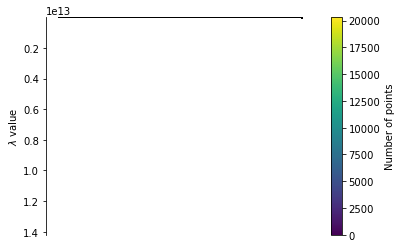

In [916]:
clusterer.condensed_tree_.plot()

**[From DBSCAN FAQ](https://hdbscan.readthedocs.io/en/latest/faq.html)**
> **Q: Most of data is classified as noise; why?**
>
> The amount of data classified as noise is controlled by the `min_samples` parameter. By default, if not otherwise set, this value is set to the same value as `min_cluster_size`. You can set it independently if you wish by specifying it separately. The lower the value, the less noise you’ll get, but there are limits, and it is possible that you simply have noisy data. See _min_samples_label for more details.


In [917]:
clusterer = hdbscan.HDBSCAN(algorithm='generic', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, #memory=Memory(cachedir=None),
    metric='cosine', min_cluster_size=5, 
                            min_samples=2, # changed this
                            p=None)
clusterer.fit(X_transformed)
clusterer.labels_.max()

774

In [918]:
np.unique(clusterer.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

I was able to reduce the samples in the noise to 11k. This is the lowest I've gotten. The problem is, I have no idea what I'm doing! Some things that worked are:
* cosine metric, and the only way to not error out was algorithm="generic" instead of "best" 
* Smaller min_samples without changing min_cluster_size. Why did this work? I don't quite get the difference. 

<AxesSubplot:ylabel='$\\lambda$ value'>

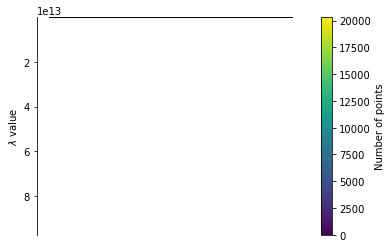

In [919]:
clusterer.condensed_tree_.plot()

In [920]:
# increase leaf size to 80
clusterer = hdbscan.HDBSCAN(algorithm='generic', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=80, #memory=Memory(cachedir=None),
    metric='cosine', min_cluster_size=5, 
                            min_samples=2, # changed this
                            p=None)
clusterer.fit(X_transformed)
print(clusterer.labels_.max())
print(np.unique(clusterer.labels_, return_counts=True)[1])

774
(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 17

In [923]:
# decrease leaf size to 10
clusterer = hdbscan.HDBSCAN(algorithm='generic', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=10, #memory=Memory(cachedir=None),
    metric='cosine', min_cluster_size=5, 
                            min_samples=2, # changed this
                            p=None)
clusterer.fit(X_transformed)
print(clusterer.labels_.max())
print(np.unique(clusterer.labels_, return_counts=True)[1])

774
[11556     8    15     7     8    10     6     5     7     5    11    21
    17    11    11     5     8    21     5    11     6     5     5     5
     7    13     8     8     9    18     6     5    13    15     5     8
    10    19     5    22     6    10     5     6     6    14    25    12
     5    10     9     5     6     6    13     6    19     7     5     5
    10    18    13     6     5    11    21     8     6     6    36    20
     9    11     6    22    11     7    19    22     5    10     9    15
     7     9     5     8     6     8    30     5     5     7    11     6
     5    20    14    14     6     9    10    10     8    21     7    15
    12     6     7    15     7     7     6     6     7     5    14     6
     5    12     5    18     7     5     9    11     6     9     7     9
    13     9    17     5     9     6     8     8     5     6    10     6
     8     8     8     8     6    12    11    12     6    10    14    10
     7     6     6     5     9     6     8    1

Cool so the leaf size didn't do anything noticeable

In [924]:
# manhattan best
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, #memory=Memory(cachedir=None),
    metric='manhattan', min_cluster_size=5, 
                            min_samples=2, # changed this
                            p=None)
clusterer.fit(X_transformed)
print(clusterer.labels_.max())
print(np.unique(clusterer.labels_, return_counts=True)[1])

842
[11897     8     6     5     9    13     7    10     5    14    11    11
    11     5    12     5     8     8     8     9    18    22     8    12
    14     5     5    14     5     6    10     7    11     6     7    11
     6     5     7    13     5    20    10     6    12     8    15     7
     8     6     7     6    11     7     5    14     8    12    21     6
     5     6     8     6    11     6     8     6    22     9    22     6
    13     8     8     5     6     5     8    10    10    22     6     8
    29     7     5    15    16     7     5     9     6     5    15     8
     5     9     5    11     6     5    11     9     9    10    11    16
    13     8    10     5     6     6     9     5     6    13     6     5
     8    15     5     5     6    15     8     6     8     6     5    10
    19     6     8    10     5     8     9     8     6     8     8    10
    10     5    13    12     5     7     5     8     6    21    21     5
     5     9    12     9    13    11    12     